<a href="https://colab.research.google.com/github/comparativechrono/panel_app_gene_enrichment/blob/main/panel_app_gene_association.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PanelApp Gene Enrichment v1.3

In this notebook we do some simple enrichment on the Genomics England gene panels pulled from the PanelApp API. The code cycles through panel app panels, gets panel IDs, and obtains the gene symbols for the green genes on each panel. Then we provide some example gene sets for enrichment analysis, and look for whether any panels are enriched in these gene sets.

# Environment preparation

In [44]:
import requests
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.stats.multitest as multi
import math
import six


# Step 1 - Data Acquisition
Get all the genes for each gene panel from the PanelApp API. Change confidence level to 2 for amber genes, currently set at 3 for green genes.

In [18]:
def get_all_panels():
    # Define the base URL
    base_url = 'https://panelapp.genomicsengland.co.uk/api/v1/'

    # Define the endpoint path
    endpoint_path = 'panels/'

    # Create the full URL
    full_url = base_url + endpoint_path

    all_panels = []

    while full_url is not None:
        # Make the request
        response = requests.get(full_url)

        # Check that the request was successful
        if response.status_code == 200:
            # Parse the response as JSON
            panels = response.json()

            # Add the results to our list
            all_panels.extend(panels['results'])

            # Get the next URL
            full_url = panels['next']
        else:
            print(f'Request failed with status code {response.status_code}')
            return None

    return all_panels

def get_genes_for_panel(panel_id, confidence_level=3):
    # Define the base URL
    base_url = 'https://panelapp.genomicsengland.co.uk/api/v1/'

    # Define the endpoint path
    endpoint_path = f'panels/{panel_id}/genes/?confidence_level={confidence_level}'

    # Create the full URL
    full_url = base_url + endpoint_path

    # Make the request
    response = requests.get(full_url)

    # Check that the request was successful
    if response.status_code == 200:
        # Parse the response as JSON
        panel_data = response.json()

        # Return the gene symbols
        return [gene['gene_data']['gene_symbol'] for gene in panel_data['results']]
    else:
        print(f'Request failed with status code {response.status_code}')
        return None

# Get all panels
all_panels = get_all_panels()

if all_panels is not None:
    # Create a DataFrame from the list of panels
    df = pd.DataFrame(all_panels)

    # Create an empty dictionary to store gene series
    genes_dict = {}

    # Iterate over the panels
    for panel_id in df['id']:
        # Get the genes for the panel
        genes = get_genes_for_panel(panel_id, 3)

        # Add the genes to the dictionary
        if genes is not None:
            genes_dict[panel_id] = pd.Series(genes, dtype='object')

    # Create a DataFrame from the dictionary
    genes_df = pd.concat(genes_dict, axis=1)

    # Save the genes DataFrame to a CSV file
    genes_df.to_csv('genes.csv')


# Step 2 - Gene Panel Enrichment Testing

Get panel names from original API request

In [19]:
panel_id_to_name = {panel['id']: panel['name'] for panel in all_panels}


### Download your dataset for looking for enrichment
Three are used in the paper:

1.   circaDB rhythmic genes (http://circadb.hogeneschlab.org/human)
2.   maternal effect genes
3.   GO:0019318 - hexose metabolic process (https://amigo.geneontology.org/amigo/term/GO:0019318)

The gene lists are stored in the `examples` directory on GitHub


In [20]:
dataset_url = "https://raw.githubusercontent.com/comparativechrono/panel_app_gene_enrichment/main/examples/circaDB.tsv"

# dataset_url = "https://raw.githubusercontent.com/comparativechrono/panel_app_gene_enrichment/main/examples/maternal.tsv"

# dataset_url = "https://raw.githubusercontent.com/comparativechrono/panel_app_gene_enrichment/main/examples/0019318.tsv"

### Perform the enrichment using Fishers exact test

Two things are outputted from this code block. First, the results of Fisher's exact test, and the FDR corrected p value. Secondly, a file containing the genes in the overlap between the gene set being tested and the panels.

In [21]:
# Load gene set
gene_set = set(pd.read_csv(dataset_url, sep='\t', header=None)[0])

# Calculate Fisher's test for each panel
results = []
overlapping_genes_dict = {}  # Create a dictionary to hold the overlapping genes
total_genes = 20449
for panel_id, panel_genes in genes_df.items():
    panel_genes = set(panel_genes.dropna())
    overlapping_genes = gene_set & panel_genes  # Get the overlapping genes
    in_gene_set_and_panel = len(gene_set & panel_genes)
    in_gene_set_and_not_panel = len(gene_set) - in_gene_set_and_panel
    in_not_gene_set_and_panel = len(panel_genes) - in_gene_set_and_panel
    in_not_gene_set_and_not_panel = total_genes - len(gene_set) - in_not_gene_set_and_panel

    contingency_table = [[in_gene_set_and_panel, in_gene_set_and_not_panel],
                         [in_not_gene_set_and_panel, in_not_gene_set_and_not_panel]]

    odds_ratio, p_value = fisher_exact(contingency_table)

    # Include panel name in results
    panel_name = panel_id_to_name[int(panel_id)]
    results.append((panel_id, panel_name, odds_ratio, p_value))

    # Store the overlapping genes for this panel
    overlapping_genes_dict[panel_name] = list(overlapping_genes)

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=['Panel ID', 'Panel Name', 'Odds Ratio', 'p-value'])

# Perform FDR correction on the p-values
result_df['q-value'] = multi.multipletests(result_df['p-value'], method='fdr_bh')[1]

# Save the DataFrame to a CSV file
result_df.to_csv('fisher_results.csv')

# Convert the overlapping genes dictionary to a DataFrame
overlapping_genes_df = pd.DataFrame(dict([ (k,pd.Series(v, dtype=object)) for k,v in overlapping_genes_dict.items() ]))

# Save the DataFrame to a CSV file
overlapping_genes_df.to_csv('overlapping_genes.csv', index=False)



# Step 3 - Data Visualization

Here we plot our output results using a simple volcano plot. The plots is scaled so that an OR of 1 is always in the centre of the plot. N.b. if a gene panel does not contain any of the genes on your list it will not be shown.

Plots of p-value and q-value vs OR

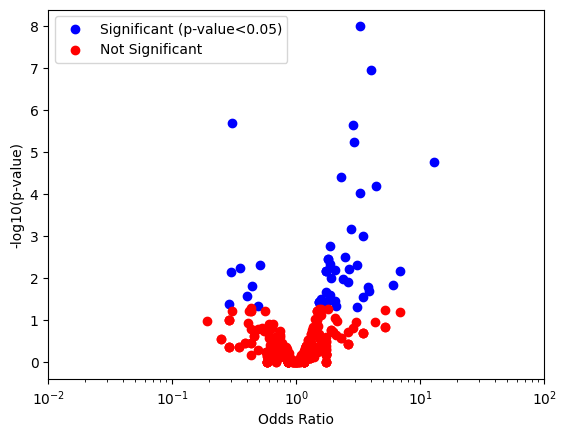

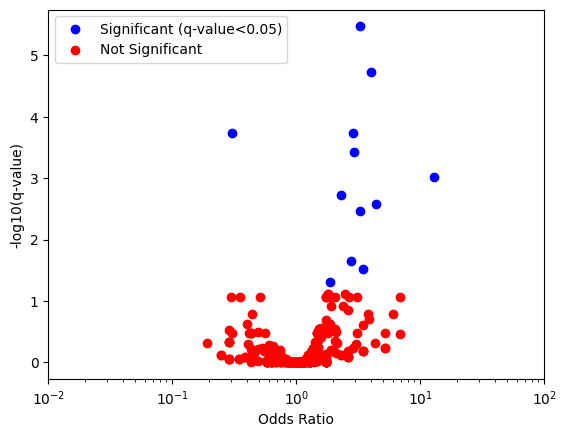

In [43]:
def create_volcano_plot(df, column, significance_level=0.05, ylabel='', filename='volcano_plot.png'):
    # Transforming column into -log10(column)
    df['-log10(' + column + ')'] = -np.log10(df[column])

    # Creating boolean masks for significant and non-significant points
    sig = df[column] < significance_level
    not_sig = df[column] >= significance_level

    # Create the figure and axis objects
    fig, ax = plt.subplots()

    # Plot the significant points in blue
    sig_scatter = ax.scatter(df['Odds Ratio'][sig], df['-log10(' + column + ')'][sig], color='blue')

    # Plot the non-significant points in red
    not_sig_scatter = ax.scatter(df['Odds Ratio'][not_sig], df['-log10(' + column + ')'][not_sig], color='red')

    # Set the scale of x axis as log scale
    ax.set_xscale('log')

    # Filter out zeros, infinities, and NaN values before calculating max and min OR values
    filtered_OR = df['Odds Ratio'].replace([np.inf, -np.inf, 0], np.nan).dropna()

    # Take the reciprocal of any OR less than 1.
    reciprocal_OR = filtered_OR.copy()
    reciprocal_OR[filtered_OR < 1] = 1 / reciprocal_OR[filtered_OR < 1]

    # Look for the maximum x value between the OR values and the reciprocal OR values.
    max_OR = max(filtered_OR.max(), reciprocal_OR.max())

    # Round this value up to the nearest value on the log scale
    max_x = 10 ** (math.ceil(math.log10(max_OR)))

    # Use this value as max_x and take its reciprocal to be min_x
    min_x = 1 / max_x

    # Set the minimum and maximum value of x-axis
    ax.set_xlim([min_x, max_x])

    # Label the axes
    ax.set_xlabel('Odds Ratio')
    ax.set_ylabel(ylabel)

    # Add the legend
    ax.legend([sig_scatter, not_sig_scatter], ['Significant (' + column + '<0.05)', 'Not Significant'])

    # Save the plot to a file
    plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()

# Create the plots
create_volcano_plot(result_df, 'p-value', ylabel='-log10(p-value)', filename='volcano_plot_p.png')
create_volcano_plot(result_df, 'q-value', ylabel='-log10(q-value)', filename='volcano_plot_q.png')


A styled table of top 10 most enriched panels

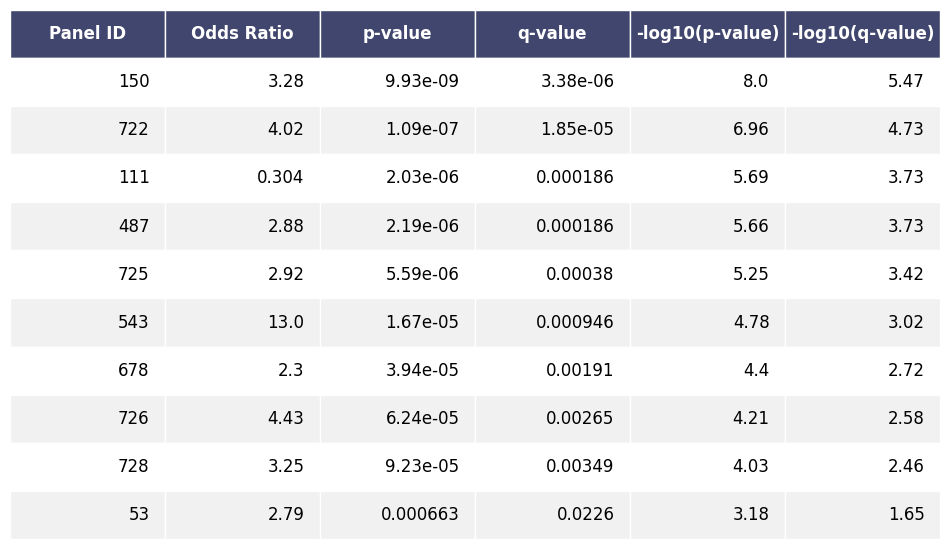

In [52]:
import matplotlib.pyplot as plt
import six

# Filter the data to only include rows with q-value less than 0.05
filtered_df = result_df[result_df['q-value'] < 0.05]

# Sort the data by q-value in ascending order and take the top 10 rows
top_10_df = filtered_df.sort_values(by='q-value', ascending=True).head(10)

# Save the top 10 rows as a figure
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors)])
    return ax.get_figure(), ax

# Convert 'Panel ID' to string
top_10_df['Panel ID'] = top_10_df['Panel ID'].astype(str)

def round_to_sigfigs(num, sig_figs):
    if num != 0:
        return round(num, -int(math.floor(math.log10(abs(num))) - (sig_figs - 1)))
    else:
        return 0  # Can't take the log of 0

# Apply the function to the DataFrame
top_10_df = top_10_df.applymap(lambda x: round_to_sigfigs(x, 3) if isinstance(x, (int, float)) else x)

# Drop the 'Panel Name' column
top_10_df = top_10_df.drop(columns='Panel Name')

fig,ax = render_mpl_table(top_10_df, header_columns=0, col_width=2.0, font_size=12)

# Save the figure
fig.savefig('top_10_significant_results.png', dpi=300)

# Display the figure in the notebook
plt.show()
